#Pixel-Wise Gland Segmentation in histology Images

###Mount Google Drive to notebook

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
#os.chdir('/content/gdrive/My Drive/Deep_Learning/final_project/')
# For thor use this line
os.chdir('/content/gdrive/My Drive/Deep_learning/final_project/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Import packages and libraries

In [0]:
from data_utils.elastic_deformation import *
from data_utils.evaluation import *

In [3]:
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset

from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
from scipy import ndimage

from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import slic, join_segmentations
from skimage.morphology import watershed
from skimage.color import label2rgb
from skimage import data, img_as_float
from skimage import exposure

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy import ndimage as ndi
import cv2
import pandas as pd

#data augmentation
!pip install elasticdeform
import imageio, elasticdeform


  Created wheel for elasticdeform: filename=elasticdeform-0.4.6-cp36-cp36m-linux_x86_64.whl size=70436 sha256=d03b770a1b6e54355bb3ee7fc4d4e6af6110e6920a66039231698469773124da
  Stored in directory: /root/.cache/pip/wheels/42/3a/94/a1d69f8b9da44826a171395e67f9f7a117f89af18f206481dd
Successfully built elasticdeform


# Read the data into numpy arrays

In [0]:
images_train,images_testA,images_testB = [],[],[]
masks_train,masks_testA,masks_testB = [],[],[]


read_size=300
img_size = 256

size_read=(read_size,read_size)
size=(img_size,img_size)
for root, dirs, files in os.walk('warwick_data/'):
   for f in files:
      if not f.endswith('anno.bmp') and not f.endswith('csv') and f.startswith('train'):
          img_path = f
          images_train.append(resize(imread(os.path.join(root, img_path)), size_read, mode='constant',anti_aliasing=True))
          
          mask_path = f[:-4]+'_anno.bmp'
          masks_train.append(resize(imread(os.path.join(root, mask_path)), size_read, mode='constant',anti_aliasing=True)>0)
      elif not f.endswith('anno.bmp') and not f.endswith('csv') and f.startswith('testA'):
          img_path = f
          images_testA.append(resize(imread(os.path.join(root, img_path)), size, mode='constant',anti_aliasing=True))
          
          mask_path = f[:-4]+'_anno.bmp'
          masks_testA.append(resize(imread(os.path.join(root, mask_path)), size, mode='constant',anti_aliasing=True)>0)
      elif not f.endswith('anno.bmp') and not f.endswith('csv') and f.startswith('testB'):
          img_path = f
          images_testB.append(resize(imread(os.path.join(root, img_path)), size, mode='constant',anti_aliasing=True))
          
          mask_path = f[:-4]+'_anno.bmp'
          masks_testB.append(resize(imread(os.path.join(root, mask_path)), size, mode='constant',anti_aliasing=True)>0)


# Pre-Processing

###Image transfer
Transfer of the individual images to numpy array.
X represents the real images and Y the corresponding sementation masks in the same order as the images


In [0]:
def to_numpy(images,masks):
    X = np.array(images, np.float32)
    Y = np.array(masks, np.float32)
    print('Loaded %d images' % len(X))
    print('Loaded %d masks' % len(Y))
    return X,Y

In [6]:
X_train,Y_train = to_numpy(images_train,masks_train)
X_testA,Y_testA = to_numpy(images_testA,masks_testA)
X_testB,Y_testB = to_numpy(images_testB,masks_testB)



Loaded 85 images
Loaded 85 masks
Loaded 60 images
Loaded 60 masks
Loaded 20 images
Loaded 20 masks


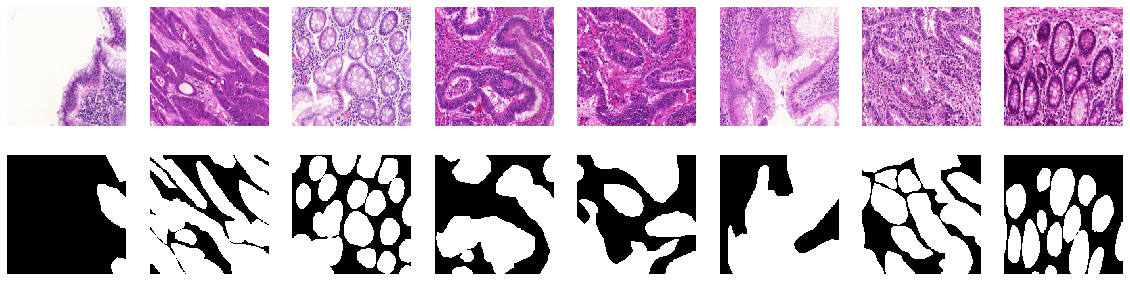

In [7]:
plt.rcParams['figure.figsize'] = [20, 5]
amount = 8
for i in range(8):
    plt.subplot(2, amount, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.subplot(2, amount, amount+1+i)
    plt.imshow(Y_train[i],cmap='gray')
    plt.axis('off')

plt.show();

**Figure 1** - Sample of the training data representing the real cell images and below their corresponding segmentation mask

## Data augmentation - Part 1
## Elastic deformation
Since the elastic deformation is computational heavy we perform it not during the training. Instead we duplicate the original dataset twice, apply two different setting of elastic deformation on them and concatenate them with the original dataset afterwards.  

In [0]:
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [0]:
def apply_transform(image,mask,sigma):
    trans_img = []
    trans_masks = []
    for idx,img in enumerate(image):
        #merge to apply elastic deformation
        im_merge = np.dstack((img, mask[idx]))
        im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 2, im_merge.shape[1] * 0.08 * sigma, im_merge.shape[1] * 0.08 * sigma)
        #split it afterwards
        trans_img.append(im_merge_t[...,:-1])
        trans_masks.append(im_merge_t[...,-1]>0)
    return trans_img,trans_masks


Elastic deformation 1 done
Elastic deformation 2 done


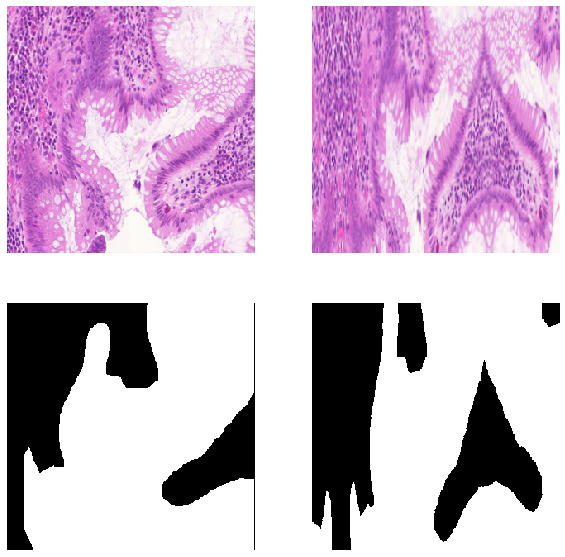

In [10]:
if True:
    X_deformed1,Y_deformed1 = apply_transform(X_train,Y_train,sigma=3)
    print('Elastic deformation 1 done')

    X_deformed2,Y_deformed2 = apply_transform(X_train,Y_train,sigma=2)
    print('Elastic deformation 2 done')

    X_train=np.concatenate((X_train,X_deformed1))
    Y_train=np.concatenate((Y_train,Y_deformed1))
    X_train=np.concatenate((X_train,X_deformed2))
    Y_train=np.concatenate((Y_train,Y_deformed2))
    no=5
    no2=2

    fig = plt.figure(figsize=(10,10))
    
    ax1 = plt.subplot(2,2,1)
    plt.imshow(X_train[no])
    plt.axis('off')


    ax2 = plt.subplot(2,2,3)
    plt.imshow(Y_train[no],cmap='gray')
    plt.axis('off')

    ax3 = plt.subplot(2,2,2)
    plt.imshow(X_deformed1[no])
    plt.axis('off')

    ax4 = plt.subplot(2,2,4)
    plt.imshow(Y_deformed1[no],cmap='gray')
    plt.axis('off')
    plt.savefig('elasticDeformSample.png',transparent=True)

**Figure 2** - Sample showing the effect of elastic deformation - Original image (left) and deformed image (right)

## Histogram Equalization
We apply histogram equalization on all images since we add some blur during the use of elastic deformation, which is potentially decreasing the performance of the training process. With the histogram equalization we adjust the contrast to overcome this problem. We apply the histogram equalization to all images including the test images to achieve better prediction results.



In [11]:
if True:
    X_train = np.array([exposure.equalize_adapthist(x, clip_limit=0.01) for x in X_train])
    X_testA = np.array([exposure.equalize_adapthist(x, clip_limit=0.01) for x in X_testA])
    X_testB = np.array([exposure.equalize_adapthist(x, clip_limit=0.01) for x in X_testB])


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to float32
  .format(dtypeobj_in, dtypeobj_out))


### Transfer the sementation mask into a two channel tensor
We transfer the image into a two channel numpy array and afterwards into a two channel tensor. After predicting the image's segmentation we compare in the loss function the argmax of the true and predicted mask

In [0]:
Y_train[Y_train>0] = 1
Y_train_re = np.zeros((Y_train.shape[0], Y_train.shape[1], Y_train.shape[2], 2),np.float32)
for i in range(2):
    Y_train_re[:,:, :, i][Y_train == i] = 1

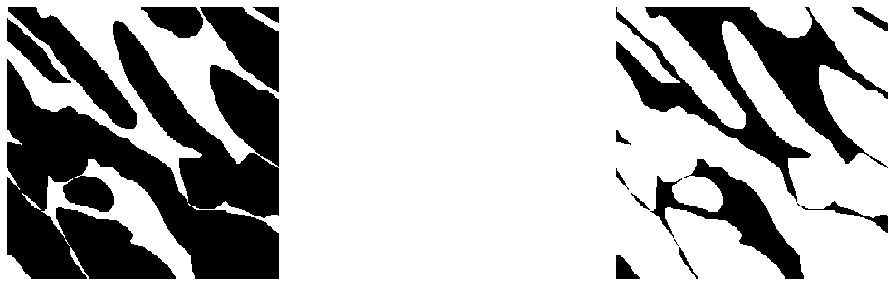

In [13]:
test = Y_train_re[1]
plt.subplot(1,2,1)
plt.imshow(test[:, :, 0],cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(test[:, :, 1],cmap='gray')
plt.axis('off')

plt.show()

**Figure 3** - Sample showing the sementation mask for background (left) and cells (right)

### Split data into training and validation data
To validate the network during the training we split the training data into two parts : the training data and validation data. For this we choose random indecies within the array and take 3/4 of the data for training and 1/4 for the validation.

In [0]:
ix = np.random.choice(len(X_train), len(X_train), False)
#print(ix)
tr, val = np.split(ix, [int(len(X_train)/4*3)]) # set better values

## Data Augmentation - Part 2
The regular transforms library for applying data augmentation only provides transformation functions only for images with text annotation. Since we have segmentation masks which represent pixelwise the annotation of the image, we need to perform data augmentation which changes the position of the pixel also to the segmentation mask. We, therefore, use the source for the needed data augmenataion types and modified it, that the transformations also getting applied to the corresponding mask in the same way, even if we apply them randomly.

In [0]:
import math
import numbers
import random

from PIL import Image, ImageOps
import numpy as np
from __future__ import division
import torch
import math
import sys
import random
from PIL import Image
try:
    import accimage
except ImportError:
    accimage = None
import numpy as np
import numbers
import types
import collections
import warnings

#import torch.nn.functional as F
import torchvision.transforms.functional as F
def _get_image_size(img):
    if F._is_pil_image(img):
        return img.size
    elif isinstance(img, torch.Tensor) and img.dim() > 2:
        return img.shape[-2:][::-1]
    else:
        raise TypeError("Unexpected type {}".format(type(img)))

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask):
        #print(img[0].size(),mask[0].size())
        #print(img.size,mask.size)
        #assert img.size == mask.size
        for t in self.transforms:
            img, mask = t(img, mask)
        return img, mask
class RandomHorizontalFlip(object):
    def __call__(self, img, mask):
        if random.random() < 0.5:
            return F.vflip(img),F.vflip(mask)
        return img, mask
class RandomVerticalFlip(object):
    def __call__(self, img, mask):
        if random.random() < 0.5:
            return F.hflip(img),F.hflip(mask)
        return img, mask
    def __repr__(self):
        return self.__class__.__name__ + '()'
class ToTensor(object):
    def __call__(self, img,mask):
        return F.to_tensor(img),F.to_tensor(mask)

    def __repr__(self):
        return self.__class__.__name__ + '()'

class ToPILImage(object):
    def __init__(self, mode=None):
        self.mode = mode
    def __call__(self, img,mask):
        return F.to_pil_image(img, self.mode),F.to_pil_image(mask, self.mode)
    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        if self.mode is not None:
            format_string += 'mode={0}'.format(self.mode)
        format_string += ')'
        return format_string
class RandomCrop(object):
    def __init__(self, size, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        self.pad_if_needed = pad_if_needed
        self.fill = fill
        self.padding_mode = padding_mode

    @staticmethod
    def get_params(img, output_size):
        w, h = _get_image_size(img)
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, img,mask):
        
        if self.padding is not None:
            img = F.pad(img, self.padding, self.fill, self.padding_mode)

        # pad the width if needed
        if self.pad_if_needed and img.size[0] < self.size[1]:
            img = F.pad(img, (self.size[1] - img.size[0], 0), self.fill, self.padding_mode)
        # pad the height if needed
        if self.pad_if_needed and img.size[1] < self.size[0]:
            img = F.pad(img, (0, self.size[0] - img.size[1]), self.fill, self.padding_mode)

        i, j, h, w = self.get_params(img, self.size)
        _,_, h_m, w_m = self.get_params(img, self.size)
        assert h==h_m and w==w_m
        return F.crop(img, i, j, h, w),F.crop(mask, i, j, h, w)

    def __repr__(self):
        return self.__class__.__name__ + '(size={0}, padding={1})'.format(self.size, self.padding)

## Creation of a Custom Dataset


In [0]:
from torchvision import transforms, utils

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None,normalize=False,mean=[0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5],img_trans=transforms.Compose([])):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform
        self.normalize = normalize
        self.norm = transforms.Compose([transforms.Normalize(mean=mean,std=std)])
        self.img_trans = img_trans

    def __getitem__(self, index):
        x = self.tensors[0][index]
        y = self.tensors[1][index]

        if self.transform:
            #joint transformations        
            x,y = self.transform(x,y)
            #individual transformations on the image
            x = self.img_trans(x)
        if self.normalize:
            x= self.norm(x)

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)



## Initialisation of the Datasets and the corresponding dataloader for the training and test process
In this part we initilize the remaining data augmentation types which will be performed randomly on every iteration of the trainings process. We apply random horizontal and vertical flip, random crop in the final model. Coller jitter decreased the performance with our test settings and is therefore not applied.
A sample batch of the different datasets (except validataion) can be seen in **Figure 4,5 and 6**

In [0]:

batch_size = 16
transform = Compose([           ToPILImage(),
                                RandomHorizontalFlip(),
                                RandomVerticalFlip(),
                                RandomCrop(img_size),
                                ToTensor()
                              ])
img_trans = transforms.Compose([
                                #transforms.ToPILImage(),
                                #transforms.ColorJitter(brightness=0, contrast=0.2, saturation=0.0, hue=.2),
                                #transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
                                #transforms.ToTensor()

])
mean = np.mean(X_train,axis=(0,1,2))
std = np.std(X_train,axis=(0,1,2))

train = CustomTensorDataset(tensors=(torch.from_numpy(np.rollaxis(X_train[tr], 3, 1)), torch.from_numpy(np.rollaxis(Y_train_re[tr],3,1))),transform= transform, normalize=True, mean=mean, std=std,img_trans=img_trans)
validation = CustomTensorDataset(tensors=(torch.from_numpy(np.rollaxis(X_train[val], 3, 1)), torch.from_numpy(np.rollaxis(Y_train_re[val],3,1))),transform= transform,normalize = True, mean = mean, std=std,img_trans=img_trans)

data_tr = DataLoader(train, batch_size=batch_size, shuffle=True)
data_val = DataLoader(validation, batch_size=batch_size, shuffle=False)

testA = CustomTensorDataset(tensors=(torch.from_numpy(np.rollaxis(X_testA, 3, 1)), torch.from_numpy(np.rollaxis(Y_testA[...,np.newaxis],3,1))), normalize=True, mean=mean, std=std)
data_testA = DataLoader(testA, batch_size=batch_size, shuffle=False)

testB = CustomTensorDataset(tensors=(torch.from_numpy(np.rollaxis(X_testB, 3, 1)), torch.from_numpy(np.rollaxis(Y_testB[...,np.newaxis],3,1))), normalize=True, mean=mean, std=std)
data_testB = DataLoader(testB, batch_size=batch_size, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2065.5, 517.5, -0.5)

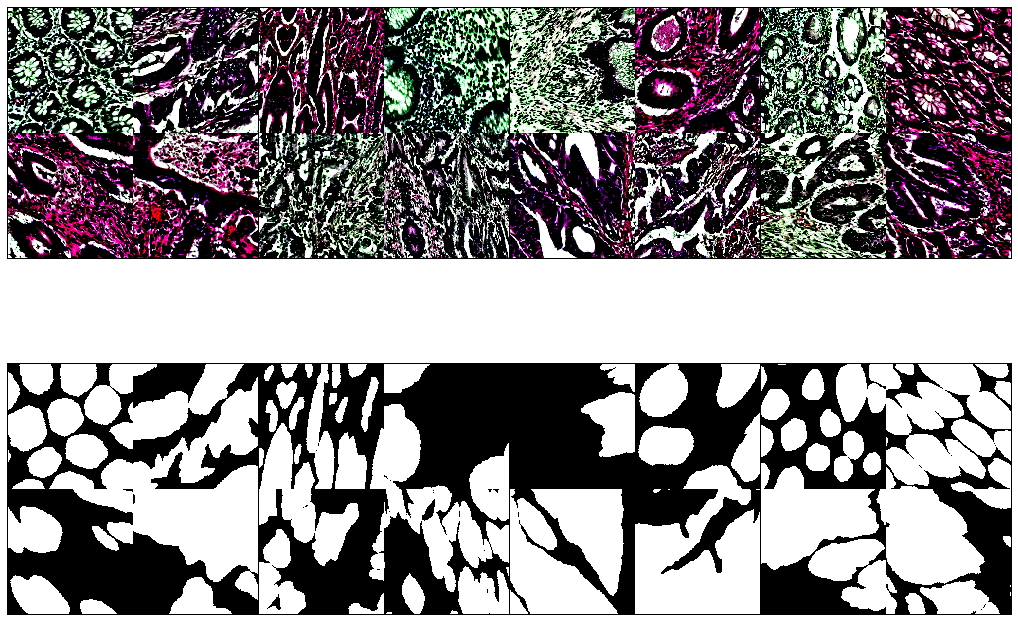

In [18]:
plt.rcParams['figure.figsize'] = [18, 12]

images,targets = next(iter(data_tr))
grid = utils.make_grid(images)
grid_m = utils.make_grid(targets[:,1,np.newaxis,...])
plt.subplot(2,1,1)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(grid_m.numpy().transpose((1, 2, 0)))
plt.axis('off')


**Figure 4** - Sample batch of training data with corresponding segmentation masks


In [19]:
print(len(X_testA),len(testA),'Length should be 60')
assert len(testA)==len(X_testA)

60 60 Length should be 60


In [20]:
print(len(X_testB),len(testB),'Length should be 20')
assert len(testB)==len(X_testB)

20 20 Length should be 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2065.5, 517.5, -0.5)

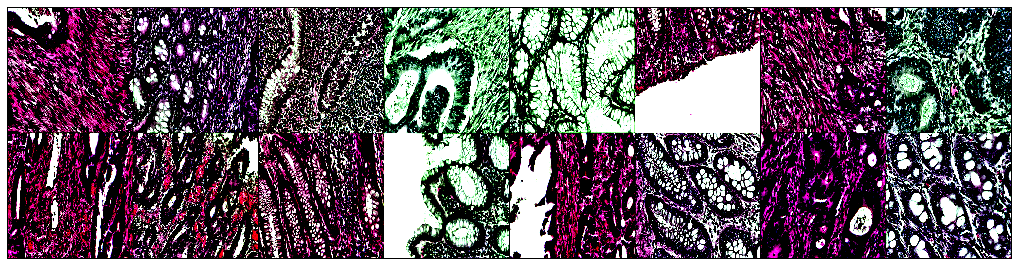

In [21]:
plt.rcParams['figure.figsize'] = [18, 6]
images,targets = next(iter(data_testA))
grid = utils.make_grid(images)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')

**Figure 5** - Sample batch of test data A


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2065.5, 517.5, -0.5)

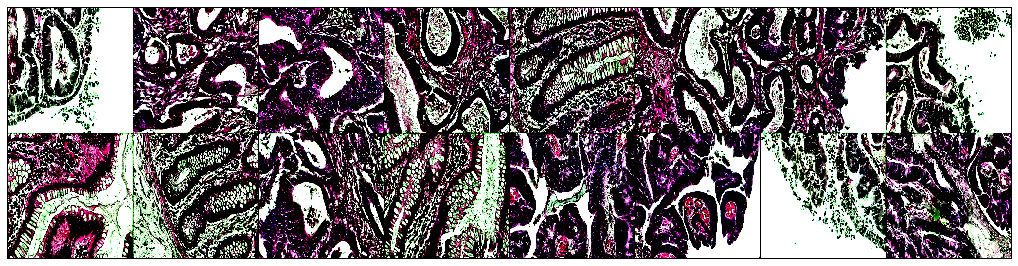

In [22]:
plt.rcParams['figure.figsize'] = [18, 6]
images,targets = next(iter(data_testB))
grid = utils.make_grid(images)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')

**Figure 6** - Sample batch of test data B


#Segmentation architectures
In our project we test two different segmentation architectures - the [U-Net](https://arxiv.org/abs/1505.04597) and the [SegNet](https://arxiv.org/abs/1511.00561). A model summary of the individual layer in the choosen Network is shown in **Table 1**.

## U-Net

In [0]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.momentum = 0.05
        self.en1 = self.encode_block(3,64,1,drop_rate=0.0)
        self.en2 = self.encode_block(64,128,1,drop_rate=0.0)
        self.en3 = self.encode_block(128,256,1,drop_rate=0.5)
        self.en4 = self.encode_block(256,512,1,drop_rate=0.5)

        self.boNe = self.bottleneck(512,1024,1,drop_rate=0.5)

        self.de4 = self.decode_block(1024,512,1,drop_rate=0.5)
        self.de3 = self.decode_block(512,256,1,drop_rate=0.5)
        self.de2 = self.decode_block(256,128,1,drop_rate=0.0)
        self.de1 = self.decode_block(128,64,1,LL=True)

        self.pool = nn.MaxPool2d(2, 2)



    def encode_block(self,input_channel, output_channel,no_layer,drop_rate=0):
        en_list = []
        en_list.extend([
                            nn.Conv2d(input_channel,output_channel,3,padding=1),
                            nn.BatchNorm2d(output_channel,momentum=self.momentum),
                            nn.ReLU()
            ])
        for i in range(no_layer):
            en_list.extend([
                            nn.Conv2d(output_channel,output_channel,3,padding=1),
                            nn.BatchNorm2d(output_channel,momentum=self.momentum),
                            nn.ReLU()
            ])
        if drop_rate > 0:
            en_list += [nn.Dropout(drop_rate)]
        return nn.Sequential(*en_list)

    def bottleneck (self,input_channel, output_channel,no_layer,drop_rate=0):
        b_list = []
        b_list.extend([
                            nn.Conv2d(input_channel,output_channel,3,padding=1),
                            nn.BatchNorm2d(output_channel,momentum=self.momentum),
                            nn.ReLU()
            ])
        for i in range(no_layer):
            b_list.extend([
                            nn.Conv2d(output_channel,output_channel,3,padding=1),
                            nn.BatchNorm2d(output_channel,momentum=self.momentum),
                            nn.ReLU()
            ])
        if drop_rate > 0:
            b_list += [nn.Dropout(drop_rate)]
        return nn.Sequential(*b_list)
    def upsample_cat(self,left_input, bottom_input):
        upsample = nn.Upsample(int(bottom_input.shape[-1]*2))  # double bottom image dimensions
        bottom_input = upsample(bottom_input)
        return torch.cat([bottom_input,left_input],1)

    def decode_block(self,input_channel, output_channel,no_layer,LL=False,drop_rate=0):
        de_list = []
        de_list.extend([
                        nn.Conv2d(input_channel+int(input_channel*0.5),output_channel,3,padding=1),
                        nn.BatchNorm2d(output_channel,momentum=self.momentum),
                        nn.ReLU()
        ])
        for i in range(no_layer):
            de_list.extend([
                            nn.Conv2d(output_channel,output_channel,3,padding=1),
                            nn.BatchNorm2d(output_channel,momentum=self.momentum),
                            nn.ReLU()
            ])
        if drop_rate > 0:
            de_list += [nn.Dropout(drop_rate)]
        if LL:
            de_list.append(nn.Conv2d(output_channel,2,3,padding=1))
        return nn.Sequential(*de_list)
    def forward(self,x):
        e1 = self.en1(x)
        x = self.pool(e1)
        e2 = self.en2(x)
        x = self.pool(e2)
        e3 = self.en3(x) 
        x = self.pool(e3)
        e4 = self.en4(x)
        x = self.pool(e4)

        b = self.boNe(x)

        d4 = self.upsample_cat(e4,b)
        d4 = self.de4(d4)
        d3 = self.upsample_cat(e3,d4)
        d3 = self.de3(d3)
        d2 = self.upsample_cat(e2,d3)
        d2 = self.de2(d2)
        d1 = self.upsample_cat(e1,d2)
        d1 = self.de1(d1)

        return d1

## SegNet

In [0]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.momentum=0.05
        self.pool = nn.MaxPool2d(2, 2,return_indices=True)
        self.upsample = nn.MaxUnpool2d(2,2)

        self.en1 = self.encode_block(3,64,2)
        self.en2 = self.encode_block(64,128,2)
        self.en3 = self.encode_block(128,256,3)
        self.en4 = self.encode_block(256,512,3)
        self.en5 = self.encode_block(512,512,3)
  
        self.de5 = self.decode_block(512,512,3)
        self.de4 = self.decode_block(512,256,3)
        self.de3 = self.decode_block(256,128,3)
        self.de2 = self.decode_block(128,64,2)
        self.de1 = self.decode_block(64,2,2,LL=True)

        self.dropout = nn.Dropout(p=0.5)

    def encode_block(self,input_channel, output_channel,no_layer):
        en_list = []
        en_list.extend([
                            nn.Conv2d(input_channel,output_channel,3,padding=1),
                            nn.BatchNorm2d(output_channel,momentum=self.momentum),
                            nn.ReLU()
            ])
        for i in range(no_layer):
            en_list.extend([
                            nn.Conv2d(output_channel,output_channel,3,padding=1),
                            nn.BatchNorm2d(output_channel,momentum=self.momentum),
                            nn.ReLU()
            ])
        en_list.append(nn.MaxPool2d(2, 2,return_indices=True))

        return nn.Sequential(*en_list)
    def decode_block(self,input_channel, output_channel,no_layer,LL=False):
        de_list = []

        for i in range(no_layer):
            de_list.extend([
                            nn.Conv2d(input_channel,input_channel,3,padding=1),
                            nn.BatchNorm2d(input_channel,momentum=self.momentum),
                            nn.ReLU()
            ])
        de_list.append(nn.Conv2d(input_channel,output_channel,3,padding=1))
        if not LL:
            de_list.extend([
                            nn.BatchNorm2d(output_channel,momentum=self.momentum),
                            nn.ReLU()
                            ])
        return nn.Sequential(*de_list)
    def forward(self,x):

        #encode blocks
        size0 = x.size()

        x,idx1 = self.en1(x)
        size1 = x.size()
        
        x,idx2 = self.en2(x)
        size2 = x.size()

        x,idx3 = self.en3(x)
        size3 = x.size()
        x = self.dropout(x)

        x,idx4 = self.en4(x)
        size4 = x.size()
        x = self.dropout(x)

        x,idx5 = self.en5(x)
        x = self.dropout(x)

        #decoder blocks
        x = self.upsample(x,idx5,output_size=size4)
        x = self.de5(x)
        x = self.dropout(x)

        x = self.upsample(x,idx4,output_size=size3)
        x = self.de4(x)
        x = self.dropout(x)

        x = self.upsample(x,idx3,output_size=size2)
        x = self.de3(x)
        x = self.dropout(x)

        x = self.upsample(x,idx2,output_size=size1)
        x = self.de2(x)

        x = self.upsample(x,idx1,output_size=size0)
        x = self.de1(x)

        return x

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [26]:
#choose eihter 'segnet' or 'unet'
use = 'segnet'
if use=='segnet':
    model = SegNet().to(device)
    summary(model, (3, 256, 256))
else:
    model = UNet().to(device)
    summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
            Conv2d-7         [-1, 64, 256, 256]          36,928
       BatchNorm2d-8         [-1, 64, 256, 256]             128
              ReLU-9         [-1, 64, 256, 256]               0
        MaxPool2d-10  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
           Conv2d-11        [-1, 128, 128, 128]          73,856
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
           Conv2d-14    

**Table 1** - Table showing the individual layer of the used network

# Helper functions - Training

## F1-Score - Evaluation method for the segmentation accuracy

In [0]:

from skimage.measure import label, regionprops
from sklearn.metrics import f1_score

def F1_score(Y_val, Y_pred):

  Y_val_label=Y_val.numpy()
  Y_pred_label=Y_pred.numpy()

  F1_score=f1_score(Y_val.reshape(-1), Y_pred.reshape(-1), average='macro')

  return F1_score

## Plot function - Unnormalize
We use a function to unnormalize the image only for plotting purposes

In [0]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

# Training

In [0]:

def train(model, opt, epochs, data_tr,data_val, data_testA,data_testB):
    #criterion = nn.BCELoss() # not possible due to multiple channels
    criterion = nn.CrossEntropyLoss()
    X_val, Y_val = next(iter(data_val))
    X_testA, Y_testA = next(iter(data_testA))
    X_testB, Y_testB = next(iter(data_testB))
    unnorm = UnNormalize(mean,std)
    loss_hist={'train':[],'test':[]}
    F1_scores_macro = {'train_mean':[],'train_std':[],'val_mean':[],'val_std':[],'testA_mean':[],'testA_std':[],'testB_mean':[],'testB_std':[]}
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_loss_train = 0
        f1_train =[]
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = criterion(Y_pred,torch.argmax(Y_batch,dim=1).long())
            for idx_,y_pred in enumerate(Y_pred):
                f1_train.append(F1_score(torch.argmax(Y_batch[idx_].detach().cpu(),dim=0),torch.argmax(y_pred.detach().cpu(),dim=0)))

            # backward
            loss.backward()  # backward-pass
            opt.step()  # update weights
            # calculate metrics to show the user
            avg_loss += loss.detach().cpu().numpy()
        avg_loss = avg_loss/len(data_tr)
        toc = time()
        loss_hist['train'].append(avg_loss)
        
        f1_temp=np.array(f1_train)
        F1_scores_macro['train_mean'].append(np.mean(f1_temp))
        F1_scores_macro['train_std'].append(np.std(f1_temp))
        # show intermediate results
        
        model.eval()  # testing mode
        #calulating loss on data_val

        f1_val = []
        for X_batch_val, Y_batch_val in data_val:
            Y_pred = torch.sigmoid(model(X_batch_val.to(device))).detach().cpu()
            avg_loss_train += criterion(Y_pred,torch.argmax(Y_batch_val,dim=1).long()).detach().cpu().numpy()
            for idx_,y_pred in enumerate(Y_pred):
                f1_val.append(F1_score(torch.argmax(Y_batch_val[idx_],dim=0),torch.argmax(y_pred,dim=0)))

        avg_loss_train =avg_loss_train/len(data_val)
        loss_hist['test'].append(avg_loss_train)
        f1_temp=np.array(f1_val)
        F1_scores_macro['val_mean'].append(np.mean(f1_temp))
        F1_scores_macro['val_std'].append(np.std(f1_temp))
        #calulating F1 on testA
        f1_testA_ep_macro =[] # temp f1 scores for all images on this epoch
        
        for X_batch_val, Y_batch_val in data_testA:
            Y_pred = torch.sigmoid(model(X_batch_val.to(device))).detach().cpu()
            for idx_,y_pred in enumerate(Y_pred):

                f1_testA_ep_macro.append(F1_score(Y_batch_val[idx_],torch.argmax(y_pred,dim=0)))
        
  

        f1_temp2=np.array(f1_testA_ep_macro)
        F1_scores_macro['testA_mean'].append(np.mean(f1_temp2))
        F1_scores_macro['testA_std'].append(np.std(f1_temp2))
        
        #calculating F1 on testB
        f1_testB_ep_macro =[] # temp f1 scores for all images on this epoch
        
        for X_batch_val, Y_batch_val in data_testB:
            Y_pred = torch.sigmoid(model(X_batch_val.to(device))).detach().cpu()
            for idx_,y_pred in enumerate(Y_pred):
                f1_testB_ep_macro.append(F1_score(Y_batch_val[idx_],torch.argmax(y_pred,dim=0)))
        
        f1_temp2=np.array(f1_testB_ep_macro)
        
        F1_scores_macro['testB_mean'].append(np.mean(f1_temp2))
        F1_scores_macro['testB_std'].append(np.std(f1_temp2))
        
        
        
        '''
        Plotting after each epoch
        '''
        Y_hat = model(X_val.to(device)).detach().cpu()
        Y_hatA = model(X_testA.to(device)).detach().cpu()
        Y_hatB = model(X_testB.to(device)).detach().cpu()

        clear_output(wait=True)
        plt.rcParams['figure.figsize'] = [18, 6]
        rows, cols = 3,7

        plt.subplot(1,cols,1)
        plt.plot(list(range(1,len(loss_hist['train'])+1)),loss_hist['train'],'-',color='cornflowerblue')
        plt.plot(list(range(1,len(loss_hist['test'])+1)),loss_hist['test'],'-',color='orange')

        plt.xlabel('epoch')
        plt.ylabel('loss')
        for k in range(2,4):
            plt.subplot(rows, cols, k)
            plt.imshow(np.rollaxis(unnorm(X_val[k].clone()).numpy(), 0, 3), cmap='gray')
            plt.title('Real - val')
            plt.axis('off')

            plt.subplot(rows, cols, k+7)
            plt.imshow(np.rollaxis(Y_val[k,1].numpy(), 0, 1), cmap='gray')
            plt.title('Original Mask')
            plt.axis('off')
            
            plt.subplot(rows, cols, k+14)
            plt.imshow(torch.argmax(Y_hat[k],dim=0), cmap='gray')
            plt.title('Prediction mask')
            plt.axis('off')
        for k in range(4,6):
            plt.subplot(rows, cols, k)
            plt.imshow(np.rollaxis(unnorm(X_testA[k].clone()).numpy(), 0, 3), cmap='gray')
            plt.title('Real - TestA')
            plt.axis('off')

            plt.subplot(rows, cols, k+7)
            plt.imshow(np.rollaxis(Y_testA[k,0].numpy(), 0, 1), cmap='gray')
            plt.title('Original Mask')
            plt.axis('off')

            plt.subplot(rows, cols, k+14)
            plt.imshow(torch.argmax(Y_hatA[k],dim=0), cmap='gray')
            plt.title('Prediction mask')
            plt.axis('off')
        for k in range(6,8):
            plt.subplot(rows, cols, k)
            plt.imshow(np.rollaxis(unnorm(X_testB[k].clone()).numpy(), 0, 3), cmap='gray')
            plt.title('Real - TestB')
            plt.axis('off')

            plt.subplot(rows, cols, k+7)
            plt.imshow(np.rollaxis(Y_testB[k,0].numpy(), 0, 1), cmap='gray')
            plt.title('Original Mask')
            plt.axis('off')
            
            plt.subplot(rows, cols, k+14)
            plt.imshow(torch.argmax(Y_hatB[k],dim=0), cmap='gray')
            plt.title('Prediction mask')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f - time:%f - F1TestA:%f - F1TestB:%f' % (epoch+1, epochs, avg_loss,toc-tic,F1_scores_macro['testA_mean'][-1],F1_scores_macro['testB_mean'][-1]))
        plt.show()
    return F1_scores_macro

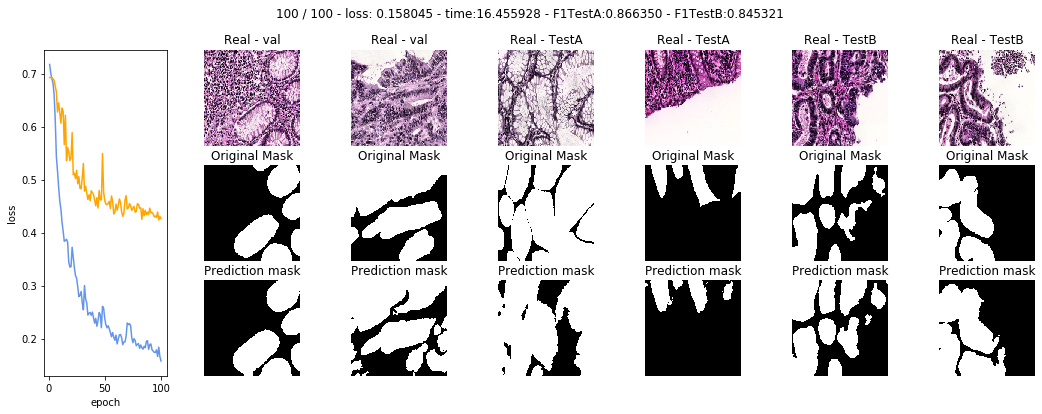

In [30]:
F1_scores=train(model, optim.AdamW(model.parameters(),lr=0.0001), 100, data_tr,data_val, data_testA,data_testB)

**Figure 7** - Intermediate results during the training process. On the left loss function of the training data (blue)and the validation data (orange) is shown. On the right two sample of each - the validation, testA and testB dataset is shown. For comparison reasons we plot the original image the original mask and the prediction result of the network.

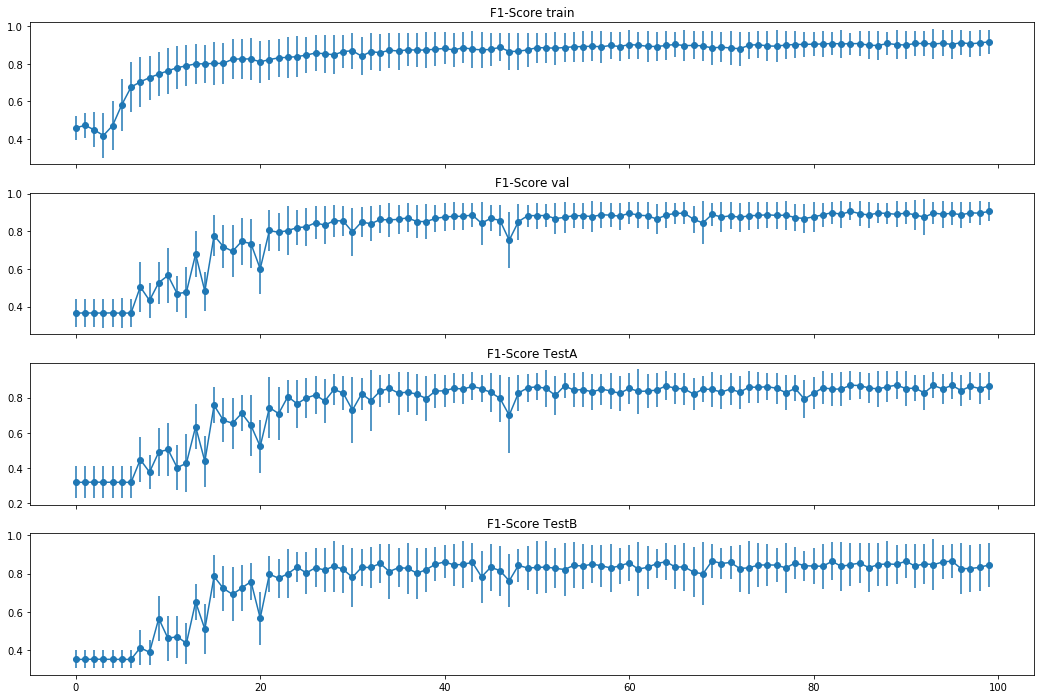

In [31]:
plt.rcParams['figure.figsize'] = [18, 12]


ig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, sharex=True);
ax0.errorbar(range(len(F1_scores['train_mean'])), F1_scores['train_mean'], yerr=F1_scores['train_std'], fmt='-o')
ax0.set_title('F1-Score train')

ax1.errorbar(range(len(F1_scores['val_mean'])), F1_scores['val_mean'], yerr=F1_scores['val_std'], fmt='-o')
ax1.set_title('F1-Score val')

ax2.errorbar(range(len(F1_scores['testA_mean'])), F1_scores['testA_mean'], yerr=F1_scores['testA_std'], fmt='-o')
ax2.set_title('F1-Score TestA')

ax3.errorbar(range(len(F1_scores['testB_mean'])), F1_scores['testB_mean'], yerr=F1_scores['testB_std'], fmt='-o')
ax3.set_title('F1-Score TestB')
plt.show()




**Figure 8** -  F1-score over the training epochs

In [32]:
print('final F1 score for TestA:',F1_scores['testA_mean'][-1])
print('final F1 score for TestB:',F1_scores['testB_mean'][-1])
print('final F1 score for train:',F1_scores['train_mean'][-1])
print('final F1 score for val:',F1_scores['val_mean'][-1])

final F1 score for TestA: 0.8663499630845901
final F1 score for TestB: 0.8453213446049629
final F1 score for train: 0.9171416999061083
final F1 score for val: 0.9052484121916566


In [33]:
print('max F1 score for TestA:',max(F1_scores['testA_mean']))
print('max F1 score for TestB:',max(F1_scores['testB_mean']))
print('max F1 score for train:',max(F1_scores['train_mean']))
print('max F1 score for val:',max(F1_scores['val_mean']))

max F1 score for TestA: 0.8720112777999248
max F1 score for TestB: 0.8669532233211135
max F1 score for train: 0.9171416999061083
max F1 score for val: 0.9065090049609102
